# Modeling Tool Prototype

Basic tool for building models using the `IFneuron` class.

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IFneuron import *

### NeuronNetwork Class

This class is used to create networks of `IFneuron` objects.

**Some notes to be aware of when using:**
- There is very little input validation, especially for adding connections. So be careful with `neuron_id` arguments
- You sort of have to run everything in the proper order. Start with adding neurons -> add connections -> set the stimulation times -> run the simulation -> collect the data.

In [2]:
class NeuronNetwork:
    '''
    Data structure for storing networks of IFneurons.
    '''
    def __init__(self, id:'str'):
        self.id = id
        self.all_neurons = {}

    def add_neuron(self, neuron_id:str):
        neuron = IFneuron(neuron_id)
        if neuron in self.all_neurons:
            print(f'Neuron: {neuron.id} already exists. Use a different id.')
            return
        self.all_neurons[neuron_id] = neuron
    
    def add_neuron_connection(self, presynaptic_neuron_id:str, postsynaptic_neuron_id:str, weight:float):
        '''
        presynaptic -> postsynaptic.
        presynaptic_neuron_id is the 'sending' neuron.
        postsynaptic_neuron_id is the 'receiving' neuron.
        '''
        connection = (self.all_neurons[presynaptic_neuron_id], weight)
        self.all_neurons[postsynaptic_neuron_id].receptors.append(connection)
        # print(f'Connection formed: {presynaptic_neuron_id} -> {postsynaptic_neuron_id}')  # If you want to see whats happening

    def set_direct_stimulation_time_ms(self, neuron_id:str, stimulation_time_ms:list):
        self.all_neurons[neuron_id].t_directstim_ms = stimulation_time_ms
        # print(f'Set neuron: {neuron_id} stim times(ms) to: {self.all_neurons[neuron_id].t_directstim_ms}')

    def run_simulation(self, run_time_ms:float, record_membrane_potential:bool):
        for step in range(run_time_ms):
            for i in self.all_neurons.values():
                i.update(step, record_membrane_potential)

    def get_neuron_spike_times_ms(self, neuron_id:str) -> list:
        '''
        Returns individual neuron spike times(ms) as a list.
        '''
        return self.all_neurons[neuron_id].t_act_ms
    
    def get_neuron_membrane_potentials(self, neuron_id:str) -> list:
        '''
        Returns individual neuron membrane potentials as a list.
        '''
        return self.all_neurons[neuron_id].Vm_recorded
    
    def get_neuron_run_time_ms(self, neuron_id:str) -> list:
        '''
        Returns individual neuron run time(ms) as a list.
        This can be used to get the run time(ms) of the system.
        '''
        return self.all_neurons[neuron_id].t_recorded_ms

    def get_all_neurons(self) -> list:
        '''
        Returns list of all neuron objects
        '''
        return list(self.all_neurons.values())
    
    def get_all_neuron_ids(self) -> list:
        '''
        Returns list of all neuron ids
        '''
        return list(self.all_neurons.keys())

    def print_all_neurons(self):
        print(self.all_neurons)

### Helper Functions

In [3]:
def plot_membrane_potential_over_time(simulation:NeuronNetwork):
    '''
    This should be able to plot all the neurons
    in a given NeuronNetwork.
    Needs testing.
    '''
    neuron_ids = simulation.get_all_neuron_ids()
    fig, ax = plt.subplots(len(neuron_ids), figsize=(10, len(neuron_ids)*2.5), sharex=True, sharey=True)
    fig.suptitle(f'{simulation.id}: Membrane potential (mV) over Time (ms)')
    fig.supxlabel('Time (ms)')
    fig.supylabel('Membrane Potential (mV)')

    for i, neuron_id in enumerate(simulation.get_all_neuron_ids()):
        ax[i].plot(simulation.get_neuron_run_time_ms(neuron_id),
                simulation.get_neuron_membrane_potentials(neuron_id),
                label='Membrane Potential (mV)')
        ax[i].axhline(simulation.get_all_neurons()[i].Vact_mV,
                    label='Threshold (mV)', linestyle='--', color='r')
        ax[i].set_title(f'{neuron_id}')
        ax[i].legend(loc='upper right')

    plt.show

The `generate_random_stimulation_times_ms` is code generated by google's gemini. But I am the one who came up with the actual logic and reasoning behind the whole distribution thing.

I chose to do the distribution thing so that we dont see clusters of spikes in the data. But, I do feel like that is an important aspect to consider. So, I'll probably need to rework this function at some point. But I believe it will work for demonstration purposes.

In [4]:
def generate_random_stimulation_times_ms(num_stims:int, max_time_ms:float, min_time_between_stim_ms:float) -> list:
    '''
    Generates ascending stimulus times. Each stim's upper bound scales with its proportion
    of `max_time_ms / num_stims`, ensuring earlier values are statistically denser while
    respecting `min_time_between_stim_ms`.
    '''
    stimulation_times = []
    current_time = 0.0
    time_per_stim_slot = max_time_ms / num_stims

    for i in range(num_stims):
        min_current_stim_time = current_time + min_time_between_stim_ms
        upper_limit_from_distribution = (i + 1) * time_per_stim_slot
        remaining_stims_to_place = num_stims - (i + 1)
        upper_limit_from_remaining_space = max_time_ms - (remaining_stims_to_place * min_time_between_stim_ms)
        upper_bound = min(upper_limit_from_distribution, upper_limit_from_remaining_space)
        lower_bound = max(min_current_stim_time, current_time)

        if lower_bound > upper_bound:
            return stimulation_times

        stim_time = lower_bound if lower_bound == upper_bound else np.random.uniform(lower_bound, upper_bound + np.finfo(float).eps)
        
        stimulation_times.append(stim_time)
        current_time = stim_time

    return stimulation_times

# print(generate_random_stimulation_times_ms(10, 5000, 100))

## Making a model

This example will use the original diagram, to keep things simple for now.

The diagram can be found here: https://docs.google.com/drawings/d/1Ff46J6rN11y0qpxOj1pYI5ceD3pyPDgKLzcZ0Jx5_uQ/edit?usp=sharing

### Creating the Ground Truth system

I chose to hold off on making a `generate_neurons` function for now so that we can better see what neurons are part of a system. This should be added later though, if we want to make example networks with random connections.

In [5]:
ground_truth_system = NeuronNetwork('Ground Truth system')

ground_truth_system.add_neuron('Neuron_A')  # input neuron
ground_truth_system.add_neuron('Neuron_B')  # input neuron
ground_truth_system.add_neuron('Neuron_C')
ground_truth_system.add_neuron('Neuron_D')
ground_truth_system.add_neuron('Neuron_E')
# ground_truth_system.print_all_neurons()

ground_truth_system.add_neuron_connection('Neuron_A', 'Neuron_C', .7)    # Neuron_A -> Neuron_C
ground_truth_system.add_neuron_connection('Neuron_B', 'Neuron_C', .7)    # Neuron_B -> Neuron_C

ground_truth_system.add_neuron_connection('Neuron_A', 'Neuron_D', 1.0)   # Neuron_A -> Neuron_D
ground_truth_system.add_neuron_connection('Neuron_B', 'Neuron_D', 1.0)   # Neuron_B -> Neuron_D

ground_truth_system.add_neuron_connection('Neuron_D', 'Neuron_E', 1.0)   # Neuron_D -> Neuron_E
ground_truth_system.add_neuron_connection('Neuron_C', 'Neuron_E', -1.0)  # Neuron_C -> Neuron_E

stim_time_ms_a = [25, 350, 700, 1000, 1400, 2000]
ground_truth_system.set_direct_stimulation_time_ms('Neuron_A', stim_time_ms_a)

stim_time_ms_b = [20, 450, 700, 1000, 1300, 2200]
ground_truth_system.set_direct_stimulation_time_ms('Neuron_B', stim_time_ms_b)

simulation_run_time_ms = 3500
ground_truth_system.run_simulation(simulation_run_time_ms, True)

## Demonstration of getters

`get_all_neurons`:

In [6]:
all_neurons = ground_truth_system.get_all_neurons()
for index, neuron in enumerate(all_neurons):
    print(f'index: {index}  |  neuron: {neuron}')

index: 0  |  neuron: <IFneuron.IFneuron object at 0x000001A7CD892900>
index: 1  |  neuron: <IFneuron.IFneuron object at 0x000001A78C652D50>
index: 2  |  neuron: <IFneuron.IFneuron object at 0x000001A7CD8BDD10>
index: 3  |  neuron: <IFneuron.IFneuron object at 0x000001A78C868050>
index: 4  |  neuron: <IFneuron.IFneuron object at 0x000001A7CD84E8B0>


---
`get_neuron_spike_times_ms`:

In [7]:
neuron_A_spike_times = ground_truth_system.get_neuron_spike_times_ms('Neuron_A')
print(f'Neuron A spike times: {neuron_A_spike_times}')

neuron_B_spike_times = ground_truth_system.get_neuron_spike_times_ms('Neuron_B')
print(f'Neuron B spike times: {neuron_B_spike_times}')

neuron_C_spike_times = ground_truth_system.get_neuron_spike_times_ms('Neuron_C')
print(f'Neuron C spike times: {neuron_C_spike_times}')

neuron_D_spike_times = ground_truth_system.get_neuron_spike_times_ms('Neuron_D')
print(f'Neuron D spike times: {neuron_D_spike_times}')

neuron_E_spike_times = ground_truth_system.get_neuron_spike_times_ms('Neuron_E')
print(f'Neuron E spike times: {neuron_E_spike_times}')

Neuron A spike times: [25, 350, 700, 1000, 1400, 2000]
Neuron B spike times: [20, 450, 700, 1000, 1300, 2200]
Neuron C spike times: [27, 704, 1004]
Neuron D spike times: [26, 357, 458, 702, 1002, 1307, 1408, 2007, 2207]
Neuron E spike times: [364, 467, 1314, 1417, 2014, 2214]


---
`get_neuron_membrane_potentials`:

In [8]:
neuron_A_membrane_potentials = ground_truth_system.get_neuron_membrane_potentials('Neuron_A')
print(f'Neuron A membrane_potentials: {neuron_A_membrane_potentials[:10]}...')

neuron_B_membrane_potentials = ground_truth_system.get_neuron_membrane_potentials('Neuron_B')
print(f'Neuron B membrane_potentials: {neuron_B_membrane_potentials[:10]}...')

neuron_C_membrane_potentials = ground_truth_system.get_neuron_membrane_potentials('Neuron_C')
print(f'Neuron C membrane_potentials: {neuron_C_membrane_potentials[:10]}...')

neuron_D_membrane_potentials = ground_truth_system.get_neuron_membrane_potentials('Neuron_D')
print(f'Neuron D membrane_potentials: {neuron_D_membrane_potentials[:10]}...')

neuron_E_membrane_potentials = ground_truth_system.get_neuron_membrane_potentials('Neuron_E')
print(f'Neuron E membrane_potentials: {neuron_E_membrane_potentials[:10]}...')

Neuron A membrane_potentials: [-60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0]...
Neuron B membrane_potentials: [-60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0]...
Neuron C membrane_potentials: [-60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0]...
Neuron D membrane_potentials: [-60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0]...
Neuron E membrane_potentials: [-60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0, -60.0]...


---
`get_neuron_run_time_ms`:

In [9]:
neuron_A_run_time = ground_truth_system.get_neuron_run_time_ms('Neuron_A')
print(f'Neuron A spike times: {neuron_A_run_time[:10]}...')

neuron_B_run_time = ground_truth_system.get_neuron_run_time_ms('Neuron_B')
print(f'Neuron B spike times: {neuron_B_run_time[:10]}...')

neuron_C_run_time = ground_truth_system.get_neuron_run_time_ms('Neuron_C')
print(f'Neuron C spike times: {neuron_C_run_time[:10]}...')

neuron_D_run_time = ground_truth_system.get_neuron_run_time_ms('Neuron_D')
print(f'Neuron D spike times: {neuron_D_run_time[:10]}...')

neuron_E_run_time = ground_truth_system.get_neuron_run_time_ms('Neuron_E')
print(f'Neuron E spike times: {neuron_E_run_time[:10]}...')

Neuron A spike times: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
Neuron B spike times: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
Neuron C spike times: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
Neuron D spike times: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
Neuron E spike times: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...


## Plotting data

### Membrane potential over time:

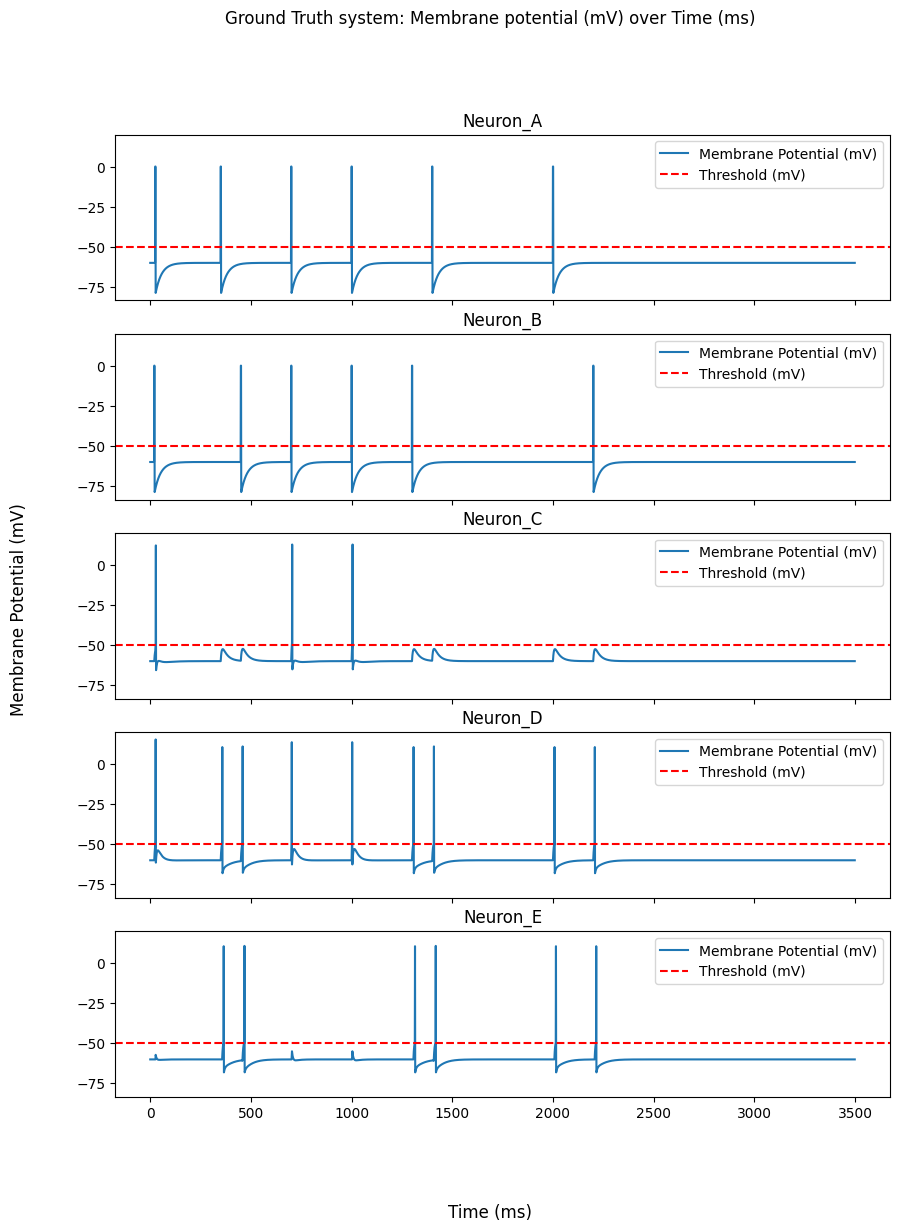

In [10]:
plot_membrane_potential_over_time(ground_truth_system)

---
# Running many simulations

I'm going to use the same code for setting up the ground truth system for this example.<br>
Also, generating random stimulation times using the `generate_random_stimulation_times_ms` function.

In [11]:
num_simulations = 100               # number of simulations to run
simulation_run_time_ms = 3000       # simulated run time
num_stims = 10                      # number of neuron stimulations
min_time_between_stims_ms = 100     # min amount of time between stimulus
all_simulations = []

for i in range(num_simulations):
    sim = NeuronNetwork(str(i))
    sim.add_neuron('Neuron_A')  # input neuron
    sim.add_neuron('Neuron_B')  # input neuron
    sim.add_neuron('Neuron_C')
    sim.add_neuron('Neuron_D')
    sim.add_neuron('Neuron_E')

    sim.add_neuron_connection('Neuron_A', 'Neuron_C', .7)    # Neuron_A -> Neuron_C
    sim.add_neuron_connection('Neuron_B', 'Neuron_C', .7)    # Neuron_B -> Neuron_C

    sim.add_neuron_connection('Neuron_A', 'Neuron_D', 1.0)   # Neuron_A -> Neuron_D
    sim.add_neuron_connection('Neuron_B', 'Neuron_D', 1.0)   # Neuron_B -> Neuron_D

    sim.add_neuron_connection('Neuron_D', 'Neuron_E', 1.0)   # Neuron_D -> Neuron_E
    sim.add_neuron_connection('Neuron_C', 'Neuron_E', -1.0)  # Neuron_C -> Neuron_E

    stims = generate_random_stimulation_times_ms(num_stims, simulation_run_time_ms, min_time_between_stims_ms)
    sim.set_direct_stimulation_time_ms('Neuron_A', stims)

    stims = generate_random_stimulation_times_ms(num_stims, simulation_run_time_ms, min_time_between_stims_ms)
    sim.set_direct_stimulation_time_ms('Neuron_B', stims)

    sim.run_simulation(simulation_run_time_ms, True)
    all_simulations.append(sim)

Quick plot of simulation 0 to make sure the data looks correct.

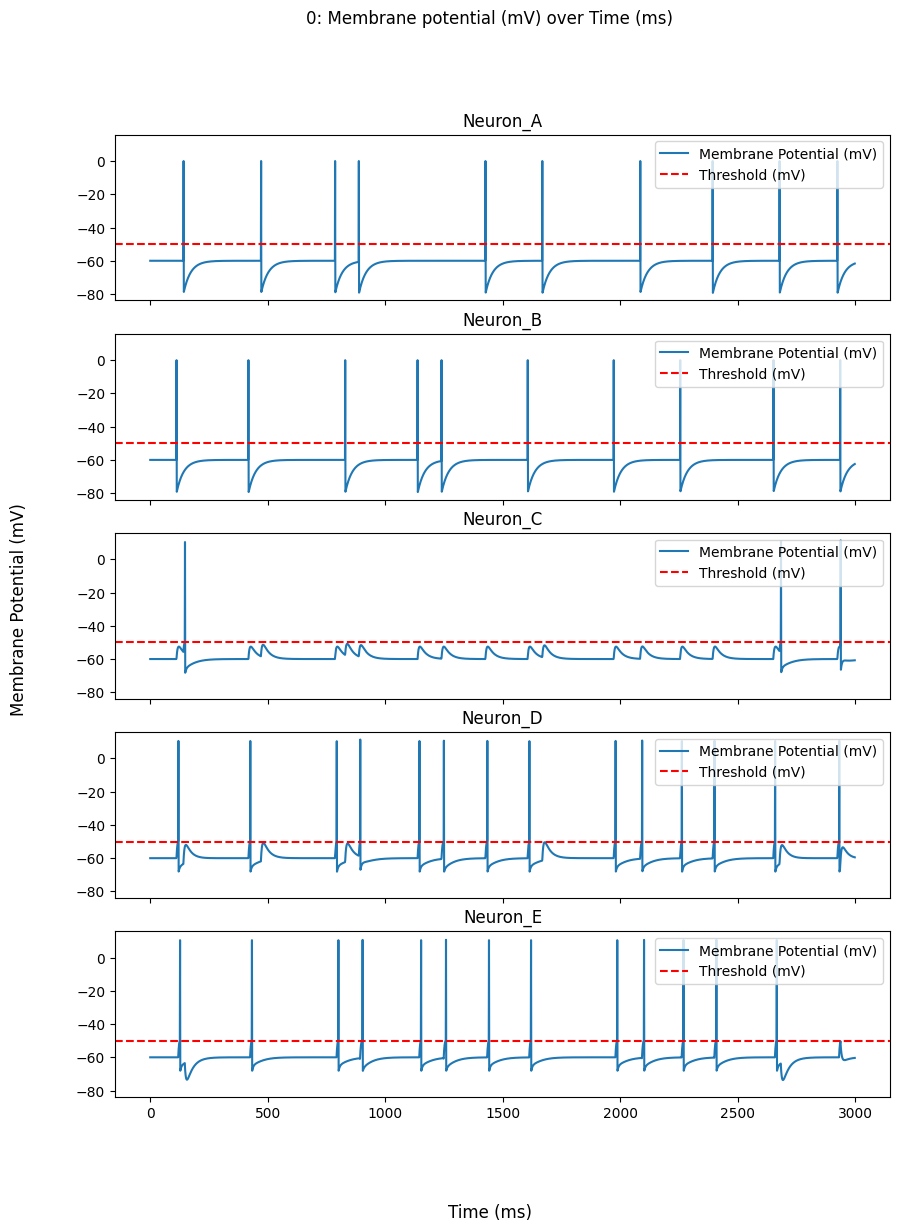

In [12]:
plot_membrane_potential_over_time(all_simulations[0])

### Histogram: Spike Count per Neuron

I am not happy with how I implemented this. But it should be able to get the job done.

I plan on reworking this, or if anyone else wants to.

In [18]:
def get_spikes_per_neuron(all_simulations:list):
    spike_counts = []
    for i, neuron_id in enumerate(all_simulations[0].get_all_neuron_ids()):
        spike_counts.append([])
        for sim in all_simulations:
            spike_counts[i].append(len(sim.get_neuron_spike_times_ms(neuron_id)))
    return spike_counts

In [38]:
def plot_spikes_per_neuron(spikes_per_neuron:list, all_neuron_ids:list):
    fig, ax = plt.subplots(1, len(all_neuron_ids), sharex=True, sharey=True, figsize=(20, 8))
    plt.rc('font', size=20)
    fig.suptitle('Spikes per Neuron')
    
    for i, neuron_id in enumerate(all_neuron_ids):
        ax[i].hist(spikes_per_neuron[i], bins=6, color='skyblue', edgecolor='black')
        ax[i].set_title(f'{neuron_id}')
        ax[i].set_xlabel('Spike Count per Neuron')
        ax[i].set_ylabel('Number of Neurons')
    
    fig.tight_layout()
    plt.show()

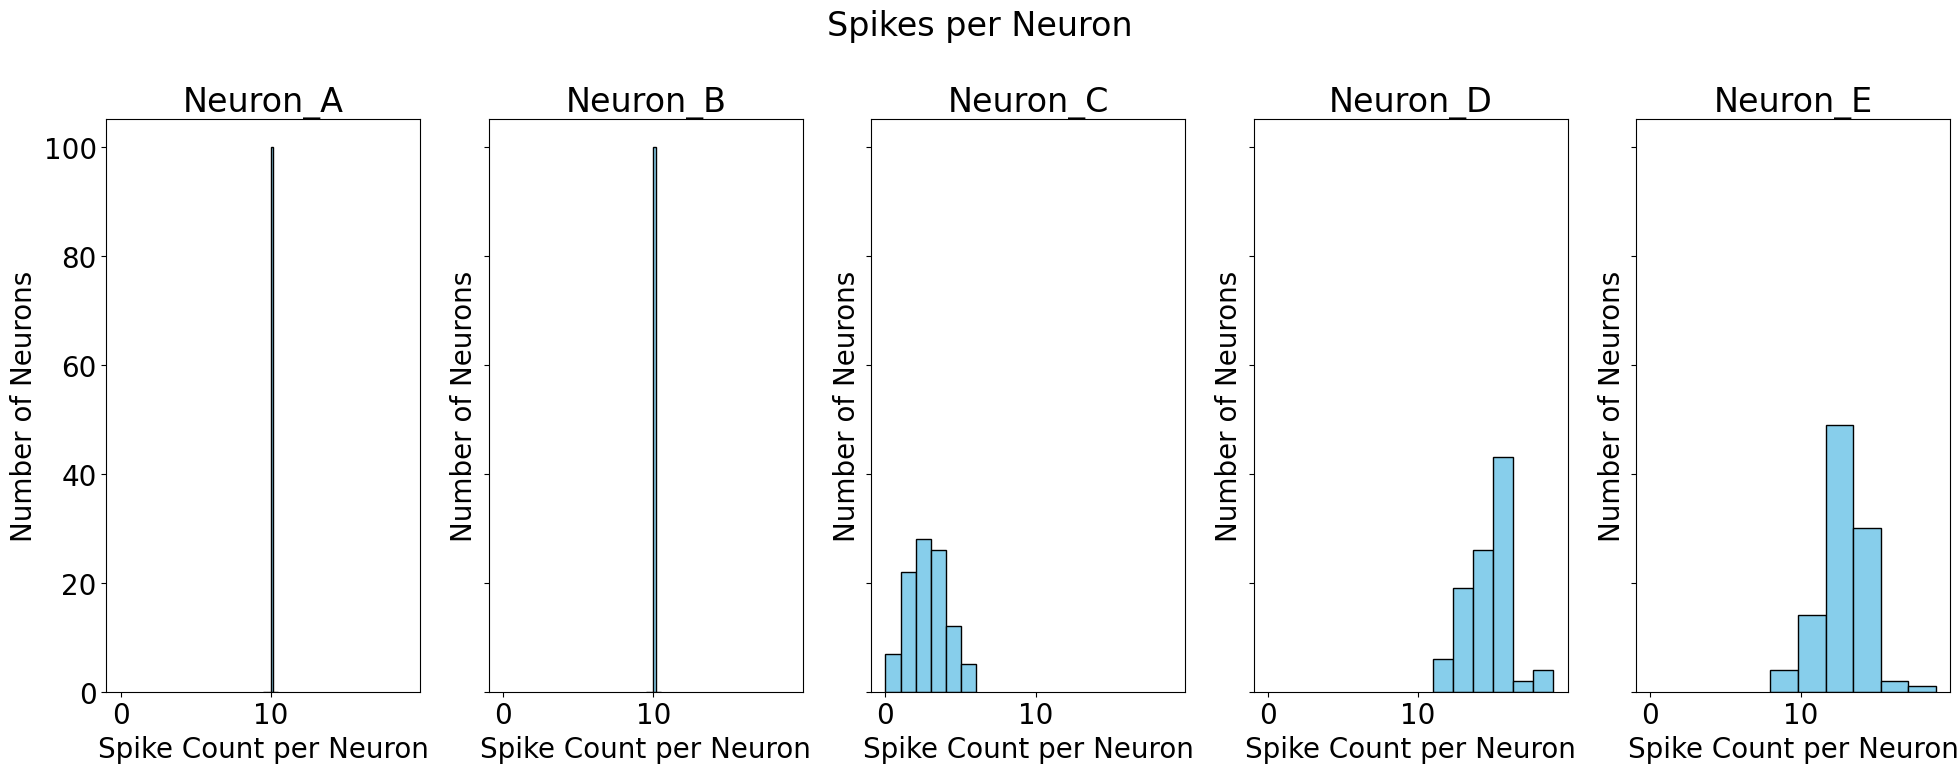

In [39]:
plot_spikes_per_neuron(get_spikes_per_neuron(all_simulations), 
                       all_simulations[0].get_all_neuron_ids())